# <font color='blue'>Objective</font>

The project explores mortgage applications submitted in 2013
The data are from the Home Mortgage Disclosure Act (HMDA) website (https://www.ffiec.gov/hmda/hmdaproducts.htm).


In [2]:
import pandas as pd
import numpy as np
#import h5py
from math import sin,cos,atan2,sqrt,radians
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# <font color='blue'>Import dataset from the csv file</font>

The CSV file is large (2.8 GB). I will read it in chuncs, filter the features of interest and append to the dataframe.

The file's format is available here: https://www.ffiec.gov/hmdarawdata/FORMATS/2013HMDALARRecordFormat.pdf
and the code sheet is here:          https://www.ffiec.gov/hmdarawdata/FORMATS/2013HMDACodeSheet.pdf




In [6]:
names = ['year','ID','agency','loan_type','property_type','loan_purpose','occupancy','loan_amount','preapproval','action','msa',
         'state','county','census','ethnicity','coethnicity','race1','race2','race3','race4','race5','corace1','corace2','corace3',
         'corace4','corace5','sex','cosex','income','purchaser','denial1','denial2','denial3','spread','hoepa','lien','edit',
         'sequence','population','min_pop','median_family_income','tract2msa_income','owner_occupied_num','sf_units_num',
         'date_ind']

dtype ={'year':int,'ID':str,'agency':str,'loan_type':int,'property_type':int,'loan_purpose':int,'occupancy':int,'loan_amount':int
        ,'preapproval':str,'action':int,'msa':str,'state':str,'county':str,'census':str,'ethnicity':str,'coethnicity':str,
        'race1':str,'race2':str,'race3':str,'race4':str,'race5':str,'corace1':str,'corace2':str,'corace3':str,'corace4':str,'corace5':str,
       'sex':int,'cosex':int,'income':str,'purchaser':str,'denial1':str,'denial2':str,'denial3':str,'spread':str,'hoepa':str,'lien':str,'edit':str,'sequence':str,
       'population':str,'min_pop':str,'median_family_income':str,'tract2msa_income':str,'owner_occupied_num':str,'sf_units_num':str,'date_ind':int}

usecols = ['year','ID','agency','loan_type','property_type','loan_purpose','loan_amount','action',
         'state','county','census','ethnicity','race1','sex','income','purchaser','spread',
         'sequence','population','median_family_income','tract2msa_income','sf_units_num','denial1']


I read the data in 1MB chuncks and keep mortgage applications that were:
1. Either originated or rejected by the lender
2. Made on single family homes
3. The purpose of the loan was home purchase (removed refinancing and home improvement)

In [7]:
data = pd.read_csv("2013HMDALAR - National/2013HMDALAR - National.csv",index_col=False,dtype=dtype,names=names,usecols = usecols ,iterator = True,chunksize=1000000)
hmda = pd.DataFrame(data = [])
for chunk in data: 
    hmda = pd.concat([hmda,chunk[((chunk['action']==1) | (chunk['action']==3)) & (chunk['property_type']==1)  & (chunk['loan_purpose']==1)]])
    print(hmda.shape)


(185270, 23)
(371042, 23)
(551973, 23)
(776140, 23)
(983002, 23)
(1199440, 23)
(1415668, 23)
(1640112, 23)
(1844782, 23)
(2064174, 23)
(2336886, 23)
(2560228, 23)
(2785072, 23)
(2972602, 23)
(3210100, 23)
(3408626, 23)
(3576380, 23)
(3578311, 23)


In [154]:
print(hmda.columns)
print(hmda.shape)

Index(['year', 'ID', 'agency', 'loan_type', 'property_type', 'loan_purpose',
       'loan_amount', 'action', 'state', 'county', 'census', 'ethnicity',
       'race1', 'sex', 'income', 'purchaser', 'denial1', 'spread', 'sequence',
       'population', 'median_family_income', 'tract2msa_income',
       'sf_units_num'],
      dtype='object')
(3578311, 23)


In [8]:
# Save HMDA data into file
hmda.to_pickle('hmda13_raw.pkl')
#store = pd.HDFStore('store_2.h5')
#store['hmda13'] = hmda
#store.close()

# <font color='blue'>Cleaning the Data</font>

In [122]:
# load data
hmda = pd.read_pickle('hmda13_raw.pkl')

In [123]:
hmda.describe()

,year,loan_type,property_type,loan_purpose,loan_amount,action,sex
count,3578311.0,3.578311e+06,3578311.0,3578311.0,3.578311e+06,3.578311e+06,3.578311e+06
mean,2013.0,1.505685e+00,1.0,1.0,2.246644e+02,1.302133e+00,1.400076e+00
std,0.0,8.203326e-01,0.0,0.0,2.393965e+02,7.162275e-01,6.355440e-01
min,2013.0,1.000000e+00,1.0,1.0,1.000000e+00,1.000000e+00,1.000000e+00
25%,2013.0,1.000000e+00,1.0,1.0,1.140000e+02,1.000000e+00,1.000000e+00
50%,2013.0,1.000000e+00,1.0,1.0,1.760000e+02,1.000000e+00,1.000000e+00
75%,2013.0,2.000000e+00,1.0,1.0,2.750000e+02,1.000000e+00,2.000000e+00
max,2013.0,4.000000e+00,1.0,1.0,9.999900e+04,3.000000e+00,4.000000e+00


## Standardize missing observations and convert strings to numbers

In [124]:
# convert income from str to int
print(hmda.shape)
hmda = hmda.drop(hmda[hmda['income'].str.find('NA') >=0].index)
hmda.loc[:,'income'] = hmda['income'].astype(int)

hmda.loc[hmda['tract2msa_income'].str.find('NA') >=0,'tract2msa_income'] = np.nan
hmda.loc[:,'tract2msa_income'] = hmda['tract2msa_income'].astype(np.float32)

hmda.loc[hmda['median_family_income'].str.find('NA') >=0,'median_family_income'] = np.nan
hmda.loc[:,'median_family_income'] = hmda['median_family_income'].astype(np.float32)

hmda.loc[pd.isnull(hmda['race1'])==True,'race1'] = '0'
hmda.loc[:,'race1'] = hmda['race1'].astype(int)

hmda.loc[(hmda['action'] == 1) | (hmda['denial1'] == ' '),'denial1'] = np.nan
hmda.loc[:,'denial1'] = hmda['denial1'].astype(np.float32)
print(hmda.shape)

(3578311, 23)
(3490541, 23)


## Identify and remove outliers

I use the z-score to identify outliers for 'loan_amount' and 'income'.  I keep observations that lie between [p25 - 1.5*IQR, p75 + 1.5*IQR]

In [125]:
# Define new variables
hmda['lti'] = hmda.loan_amount/hmda.income                       # loan-to-income ratio
hmda['rel_inc'] = hmda.income*1000/hmda.median_family_income     # income of borrower relative to the median income in the MSA
hmda['log_loan_amount'] = np.log(hmda['loan_amount'])            # log of the loan amount  
hmda['log_income'] = np.log(hmda['income'])                      # log of income 


In [126]:
#Compute the Z-score
scaler = StandardScaler()
scaler = scaler.fit(hmda.loan_amount.values.reshape(-1,1))
hmda['loan_amount_norm'] = scaler.transform(hmda.loan_amount.values.reshape(-1,1))
scaler = scaler.fit(hmda.income.values.reshape(-1,1))
hmda['income_norm'] = scaler.transform(hmda.income.values.reshape(-1,1))
scaler = scaler.fit(hmda.lti.values.reshape(-1,1))
hmda['lti_norm'] = scaler.transform(hmda.lti.values.reshape(-1,1))

c:\users\aya\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [127]:
def find_outlier(x,p25=0,p75=0,p1=0,p99=0,method='pct'):    
    if (method == 'iqr'):        
        iqr = p75 - p25
        #print(p75,p25,iqr)
        assert (iqr > 0), "p75 must be larger than p25"            
        return (x > p75 + 1.5*iqr) or (x < p25 - 1.5*iqr)
    else:        
        assert (p1<p99), "p1 must be smaller than p99"
        return (x>p99) or (x<p1)

In [128]:
hmda[['loan_amount_norm','income_norm']].describe(percentiles = [0.01,0.25,0.50,0.75,0.99])
pcnt = np.percentile(hmda.loan_amount_norm,[25,75])
hmda['loan_amount_outlier'] = hmda['loan_amount_norm'].map(lambda x: find_outlier(x,p25=pcnt[0],p75=pcnt[1],method = 'iqr'))
pcnt = np.percentile(hmda.income_norm,[25,75])
hmda['income_outlier'] = hmda['income_norm'].map(lambda x: find_outlier(x,p25=pcnt[0],p75=pcnt[1],method = 'iqr'))
pcnt = np.percentile(hmda.lti_norm,[25,75])
hmda['lti_outlier'] = hmda['lti_norm'].map(lambda x: find_outlier(x,p25=pcnt[0],p75=pcnt[1],method = 'iqr'))
hmda = hmda[(hmda['loan_amount_outlier'] == False) & (hmda['income_outlier'] == False) & (hmda['lti_outlier'] == False)]
hmda[['loan_amount_norm','income_norm']].describe(percentiles = [0.01,0.25,0.50,0.75,0.99])


,loan_amount_norm,income_norm
count,3.123995e+06,3.123995e+06
mean,-1.686889e-01,-1.646276e-01
std,4.726296e-01,2.807289e-01
min,-1.017277e+00,-6.682664e-01
1%,-9.396461e-01,-5.555501e-01
25%,-5.195239e-01,-3.802137e-01
50%,-2.637974e-01,-2.299253e-01
75%,1.060928e-01,-1.075477e-02
99%,1.124432e+00,6.592809e-01
max,1.329927e+00,7.594732e-01


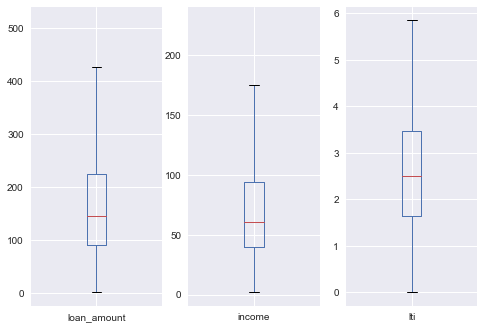

In [129]:
#plot the distributions
hmda.dropna().plot(y = ['loan_amount','income','lti'],kind = 'box',subplots = True)
plt.show()

# <font color='blue'>Merge with HMDA lender file</font>

The HMDA lender file has information on the type of lender.

In [130]:
d = {'data':[]}
with open(r'2013HMDALAR - National/2013HMDAReporterPanel/2013HMDAReporterPanel.DAT') as f:    
    for line in f:
        d['data'].append(line)

In [131]:
reporter = pd.DataFrame(d)
reporter['ID'] = reporter.data.str[4:14]
reporter['agency'] = reporter.data.str[14:15]
reporter['name'] = reporter.data.str[95:125]
reporter['lender_type'] = reporter.data.str[94:95]
del reporter['data']
print(reporter.columns)

Index(['ID', 'agency', 'name', 'lender_type'], dtype='object')


In [132]:
hmda = hmda.merge(reporter,on=['ID','agency'],how = 'inner')

print(hmda.shape)
print(hmda.columns)

(3123995, 35)
Index(['year', 'ID', 'agency', 'loan_type', 'property_type', 'loan_purpose',
       'loan_amount', 'action', 'state', 'county', 'census', 'ethnicity',
       'race1', 'sex', 'income', 'purchaser', 'denial1', 'spread', 'sequence',
       'population', 'median_family_income', 'tract2msa_income',
       'sf_units_num', 'lti', 'rel_inc', 'log_loan_amount', 'log_income',
       'loan_amount_norm', 'income_norm', 'lti_norm', 'loan_amount_outlier',
       'income_outlier', 'lti_outlier', 'name', 'lender_type'],
      dtype='object')


In [133]:

# catagorize race, action, type of loan and type of lender

hmda.loc[hmda['race1']>5,'race1'] = 0
hmda['race_cat'] = pd.Categorical.from_codes(hmda['race1'], categories=['NA','Native','Asian','African American','Pacific Islander','White'])

hmda.loc[hmda['action'] ==3,'action'] = 0
hmda['action_cat'] = pd.Categorical.from_codes(hmda['action'], categories=['reject','accept'])

hmda.loc[:,'loan_type'] = hmda['loan_type'] - 1
hmda['loan_type_cat'] = pd.Categorical.from_codes(hmda['loan_type'], categories=['conventional','FHA','VA','FSA'])

hmda['lender_type'] = hmda['lender_type'].astype(int)
hmda.loc[hmda['lender_type']==5,'lender_type'] = 4
hmda['lender_type_cat'] = pd.Categorical.from_codes(hmda['lender_type'], categories=['Depository','Depository MBS','BHC MBS','HUD','Affiliate'])

hmda.loc[pd.isnull(hmda['denial1'])==True,'denial1'] = 0
hmda.loc[:,'denial_cat'] = pd.Categorical.from_codes(hmda['denial1'].astype(int) , categories=['NA','Debt-to-income','Employment hist','Credit hist','Collateral','Insuf cash','Unverifiable info','Incomplete app','Insurance denied','Other'])



In [134]:
hmda.to_pickle('hmda13_clean.pkl')

# <font color='blue'> Exploring the Dataset</font>

In [135]:
hmda = pd.read_pickle('hmda13_clean.pkl')
hmda.describe()
#hmda.shape
#print(hmda.columns)

,year,loan_type,property_type,loan_purpose,loan_amount,action,race1,sex,income,denial1,median_family_income,tract2msa_income,lti,rel_inc,log_loan_amount,log_income,loan_amount_norm,income_norm,lti_norm,lender_type
count,3123995.0,3.123995e+06,3123995.0,3123995.0,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.085841e+06,3.085164e+06,3.123995e+06,3.085841e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06,3.123995e+06
mean,2013.0,5.551869e-01,1.0,1.0,1.868272e+02,8.523282e-01,4.298645e+00,1.373291e+00,8.142758e+01,4.568874e-01,6.668797e+04,1.150591e+02,2.555697e+00,1.247926e+00,5.049766e+00,4.249495e+00,-1.686889e-01,-1.646276e-01,-1.562437e-02,1.359114e+00
std,0.0,8.456840e-01,0.0,0.0,1.034983e+02,3.547744e-01,1.511225e+00,5.681524e-01,4.483044e+01,1.525473e+00,1.328832e+04,3.809876e+01,1.154413e+00,7.072392e-01,6.672302e-01,5.596040e-01,4.726296e-01,2.807289e-01,2.165015e-01,1.445801e+00
min,2013.0,0.000000e+00,1.0,1.0,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.640000e+04,3.890000e+00,4.424779e-03,1.626016e-02,0.000000e+00,0.000000e+00,-1.017277e+00,-6.682664e-01,-4.940962e-01,0.000000e+00
25%,2013.0,0.000000e+00,1.0,1.0,1.100000e+02,1.000000e+00,5.000000e+00,1.000000e+00,4.700000e+01,0.000000e+00,5.860000e+04,9.028000e+01,1.742857e+00,7.250755e-01,4.700480e+00,3.850148e+00,-5.195239e-01,-3.802137e-01,-1.680664e-01,0.000000e+00
50%,2013.0,0.000000e+00,1.0,1.0,1.660000e+02,1.000000e+00,5.000000e+00,1.000000e+00,7.100000e+01,0.000000e+00,6.510000e+04,1.101800e+02,2.474227e+00,1.077170e+00,5.111988e+00,4.262680e+00,-2.637974e-01,-2.299253e-01,-3.090353e-02,1.000000e+00
75%,2013.0,1.000000e+00,1.0,1.0,2.470000e+02,1.000000e+00,5.000000e+00,2.000000e+00,1.060000e+02,0.000000e+00,7.270000e+04,1.343400e+02,3.311688e+00,1.597444e+00,5.509388e+00,4.663439e+00,1.060928e-01,-1.075477e-02,1.261560e-01,3.000000e+00
max,2013.0,3.000000e+00,1.0,1.0,5.150000e+02,1.000000e+00,5.000000e+00,4.000000e+00,2.290000e+02,9.000000e+00,1.122000e+05,4.993500e+02,5.851351e+00,1.396341e+01,6.244167e+00,5.433722e+00,1.329927e+00,7.594732e-01,6.024506e-01,4.000000e+00


## Plot Distributions

I begin by looking at the distribution of loan amount, borrower income and loan-to-income ratio. Both are log normally distributed. loan amount has an increase in frequency around 420K which is close to the conforming loan limit (the max loan amount that can be sold to Fannie Mae and Freddie Mac).



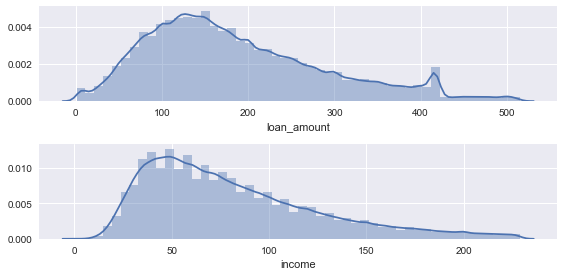

In [136]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
sns.distplot(hmda.loan_amount,ax=ax1)

ax2 = fig.add_subplot(312)
sns.distplot(hmda.income,ax=ax2)

plt.tight_layout()

plt.show()

## The Lenders

There are 5 types of lenders: depository institutions, subsidiaries of depositories, subsidiaries of bank holding companies (BHCs), independent mortgage companies (HUD) and affiliated mortgage companies. We see that the majority of applications were received by depository institutions and mortgge companies. We can also see that depositories rejected a higher fraction of their applications.

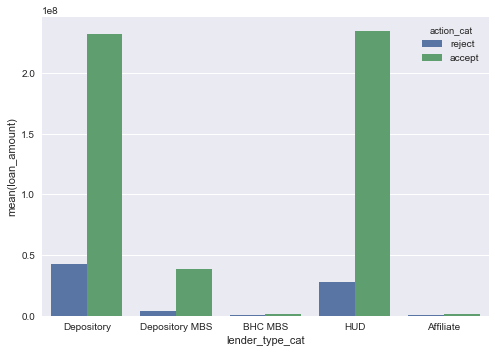

In [137]:
hmda_view = hmda.groupby(['lender_type_cat','action_cat'])['loan_amount'].sum().reset_index()
sns.barplot(x = 'lender_type_cat',y = 'loan_amount',data=hmda_view,hue='action_cat')
plt.show()

Looking at the top 50 lenders, Wells Fargo receives the majority of applications, followed by JP Morgan. We can see that most of the lending is done through depository institutions

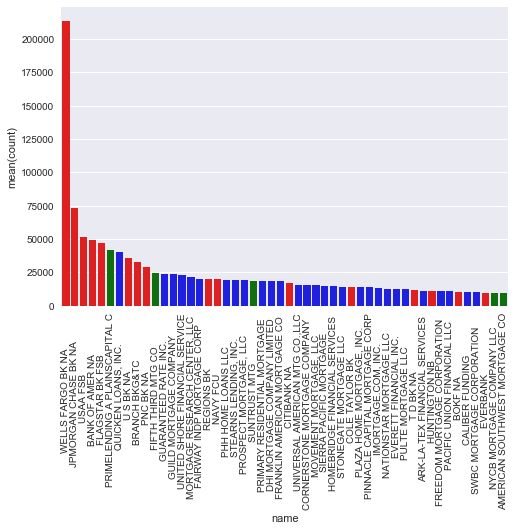

In [138]:
lenders = hmda.groupby(['name','lender_type_cat'])['loan_amount'].agg({'count':np.size}).reset_index()
lenders = lenders.sort_values('count',ascending=False).reset_index()
#print(lenders.loc[:,'lender_type_cat'].unique())

def set_color(x):    
    if (x == 'Depository'):
        return 'red'
    elif (x == 'Depository MBS'):
        return 'green'
    elif (x == 'HUD'):
        return 'blue'
    elif (x == "BHC MBS"):
        return 'yellow'
    else:
        return 'purple'
#print(lenders)
clrs = list(map(set_color,lenders.loc[0:50,'lender_type_cat']))
f1=sns.barplot(x = 'name',y = 'count',data=lenders[0:50],palette=clrs)
plt.setp(f1.get_xticklabels(), rotation=90)
plt.show()

## Loan characteristics

Compare the distribution of loans that were accepted to those that were rejected:
1. While there are many loans with low loan-to-income that were rejected, those with high loan-to-income ratio were more likely to be rejected.
2. Larger loans were more likely to be accepted. This is likely due to the positive correlation between loan amount and borrower income
3. Applications made in richer census tracts (compared to the average income in the MSA) were more likely to be accepted

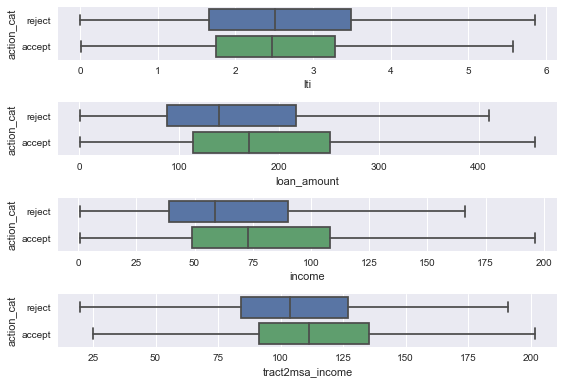

In [139]:
fig = plt.figure()
ax1 = fig.add_subplot(411)
sns.boxplot(x="lti", y="action_cat", data=hmda,showfliers = False,ax=ax1);

ax2 = fig.add_subplot(412)
sns.boxplot(x="loan_amount", y="action_cat", data=hmda,showfliers = False,ax=ax2);

ax3 = fig.add_subplot(413)
sns.boxplot(x="income", y="action_cat", data=hmda,showfliers = False,ax=ax3);

ax4 = fig.add_subplot(414)
sns.boxplot(x="tract2msa_income", y="action_cat", data=hmda,showfliers = False,ax=ax4);

plt.tight_layout()
plt.show()


The figure below examines correlation between the loan-to-income ratio, log income, log loan amount, relative income and tract to MSA income.
We can see that loans with high loan-to-income ratio are more likely to be rejected. The plots also show that those in low income tract take loans with higher loan-to-income ratio. The same holds true for those with low relative income

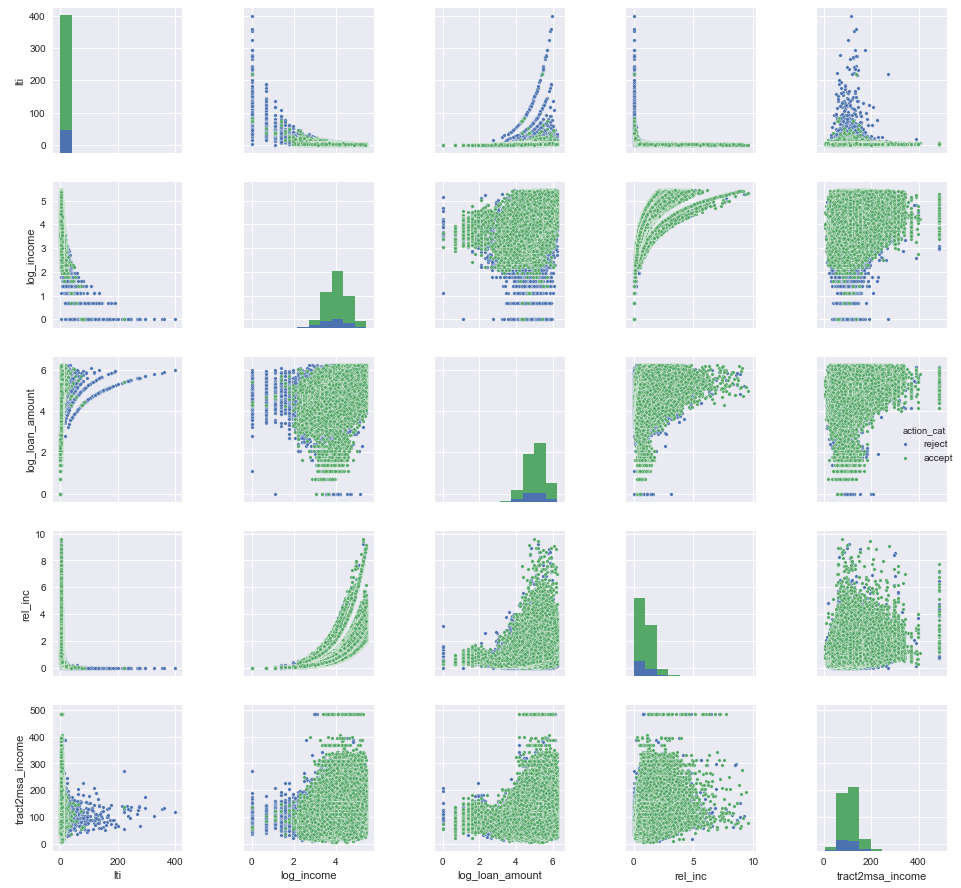

In [149]:
#Find correlations between the variables
sns.pairplot(data=hmda.dropna(), vars=['lti','log_income','log_loan_amount','rel_inc','tract2msa_income'],hue='action_cat',markers = '.')
plt.tight_layout()
plt.show()

## Rejection rates

There are more rejections in low income census tracts for borrowers with lower relative income. The race is also correlated with rejection rates as African Americans have a rejection rate that is twice the rejection rate of white population

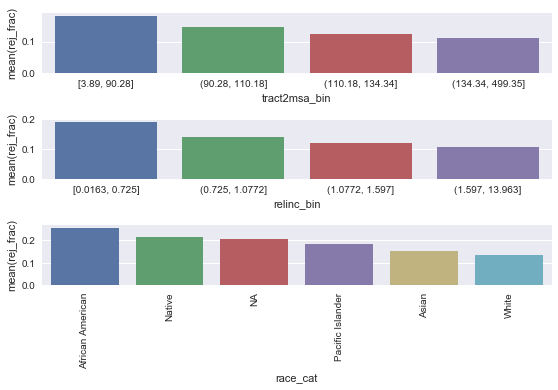

In [140]:
hmda['tract2msa_bin'] = pd.qcut(hmda['tract2msa_income'],q = [0,0.25,0.5,0.75,1])

hmda_view = hmda.groupby(['tract2msa_bin','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['tract2msa_bin'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['tract2msa_bin','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='tract2msa_bin',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)

fig = plt.figure()
ax1 = fig.add_subplot(311)
f1 = sns.barplot(x = 'tract2msa_bin',y = 'rej_frac',data=hmda_view,ax=ax1)
#plt.setp(f1.get_xticklabels(), rotation=90)



hmda['relinc_bin'] = pd.qcut(hmda['rel_inc'],q = [0,0.25,0.5,0.75,1])
hmda_view = hmda.groupby(['relinc_bin','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['relinc_bin'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['relinc_bin','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='relinc_bin',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)
ax2 = fig.add_subplot(312)
sns.barplot(x = 'relinc_bin',y = 'rej_frac',data=hmda_view,ax=ax2)
#plt.setp(f1.get_xticklabels(), rotation=90)



hmda_view = hmda.groupby(['race_cat','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['race_cat'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['race_cat','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='race_cat',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)
ax3 = fig.add_subplot(313)
f2 = sns.barplot(x = 'race_cat',y = 'rej_frac',data=hmda_view,ax=ax3)
plt.setp(f2.get_xticklabels(), rotation=90)

'''
hmda['unit_per_pop'] = hmda['sf_units_num']/hmda['population']
hmda['unit_per_pop_bin'] = pd.qcut(hmda['unit_per_pop'],q = [0,0.25,0.5,0.75,1])
hmda_view = hmda.groupby(['unit_per_pop_bin','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['unit_per_pop_bin'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['unit_per_pop_bin','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='unit_per_pop_bin',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)
ax4 = fig.add_subplot(224)
f1 = sns.barplot(x = 'unit_per_pop_bin',y = 'rej_frac',data=hmda_view,ax=ax4)
plt.setp(f1.get_xticklabels(), rotation=90)
'''
plt.tight_layout()
plt.show()
#hmda_view = hmda.groupby(['tract2msa_bin','action_cat'])['loan_amount'].count().reset_index()
#sns.barplot(x = 'tract2msa_bin',y = 'loan_amount',data=hmda_view,hue='action_cat')
#plt.show()

## Rejection rate by state
The three states with the most applications were Texas, California and Florida. Puerto Rico had the highest rejection rate (>30%), followed by Florida (>20%)

In [141]:
state_dict = {'01':'AL','02':'AK','04':'AZ', '05':'AR','06':'CA','08':'CO','09':'CT','10':'DE','11':'DC',
              '12':'FL','13':'GA','66':'GU','15':'HI','16':'ID','17':'IL','18':'IN','19':'IA','20':'KS','21':'KY','22':'LA',
              '23':'ME','24':'MD','25':'MA','26':'MI','27':'MN','28':'MS','29':'MO','30':'MT','31':'NE','32':'NV','33':'NH',
              '34':'NJ','35':'NM','36':'NY','37':'NC','38':'ND','39':'OH','40':'OK','41':'OR','42':'PA','72':'PR','44':'RI',
              '45':'SC','46':'SD','47':'TN','48':'TX','49':'UT','50':'VT','51':'VA','78':'VI','53':'WA','54':'WV','55':'WI','56':'WY'}
              


In [142]:
hmda = hmda[pd.isnull(hmda['state'])==False]
hmda.loc[:,'state_abbrv'] = list(map(lambda x:state_dict[x],hmda['state']))

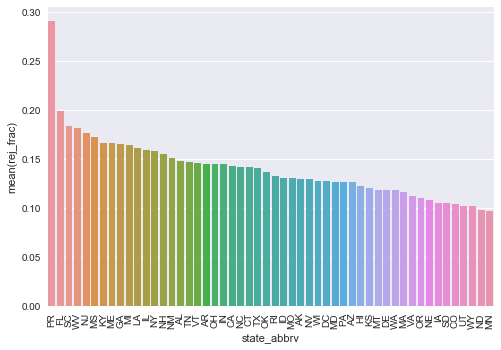

In [143]:
hmda['action_cat'] = hmda['action_cat'].astype(str)
hmda_view = hmda.groupby(['state_abbrv','action_cat'])['loan_amount'].count().reset_index()
hmda_view_tot = hmda.groupby(['state_abbrv'])['loan_amount'].count().reset_index()
hmda_view_tot.columns = ['state_abbrv','total']
hmda_view = hmda_view.merge(hmda_view_tot,on='state_abbrv',how='inner')
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
hmda_view['rej_frac'] = hmda_view['loan_amount']/hmda_view['total']
hmda_view = hmda_view.sort_values('rej_frac',ascending=False)
fig, ax = plt.subplots()
f1 = sns.barplot(x = 'state_abbrv',y = 'rej_frac',data=hmda_view,ax=ax)
plt.setp(f1.get_xticklabels(), rotation=90)
plt.show()

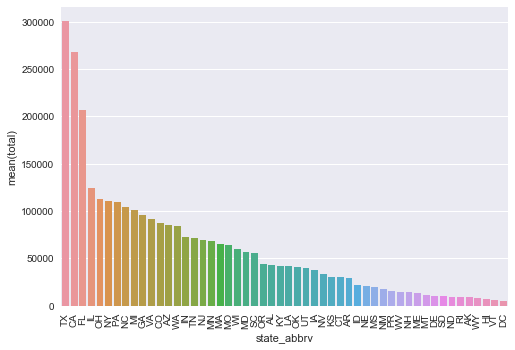

In [144]:
hmda_view_tot = hmda_view_tot.sort_values('total',ascending=False)
fig, ax = plt.subplots()
f1 = sns.barplot(x = 'state_abbrv',y = 'total',data=hmda_view_tot,ax=ax)
plt.setp(f1.get_xticklabels(), rotation=90)

plt.show()

In [145]:
#hmda.loc[hmda['population'].str.find('NA') >=0,'population'] = np.nan
#hmda['population'] = hmda['population'].astype(np.float32)
#hmda.loc[hmda['sf_units_num'].str.find('NA') >=0,'sf_units_num'] = np.nan
#hmda['sf_units_num'] = hmda['sf_units_num'].astype(np.float32)
print(hmda.columns)

Index(['year', 'ID', 'agency', 'loan_type', 'property_type', 'loan_purpose',
       'loan_amount', 'action', 'state', 'county', 'census', 'ethnicity',
       'race1', 'sex', 'income', 'purchaser', 'denial1', 'spread', 'sequence',
       'population', 'median_family_income', 'tract2msa_income',
       'sf_units_num', 'lti', 'rel_inc', 'log_loan_amount', 'log_income',
       'loan_amount_norm', 'income_norm', 'lti_norm', 'loan_amount_outlier',
       'income_outlier', 'lti_outlier', 'name', 'lender_type', 'race_cat',
       'action_cat', 'loan_type_cat', 'lender_type_cat', 'denial_cat',
       'tract2msa_bin', 'relinc_bin', 'state_abbrv'],
      dtype='object')


## Reasons for application denial

Breaking down the rejected applications based on their reason for denial, we can see that most rejections were due to high debt-to-income ratio, followed by credit history and collateral.

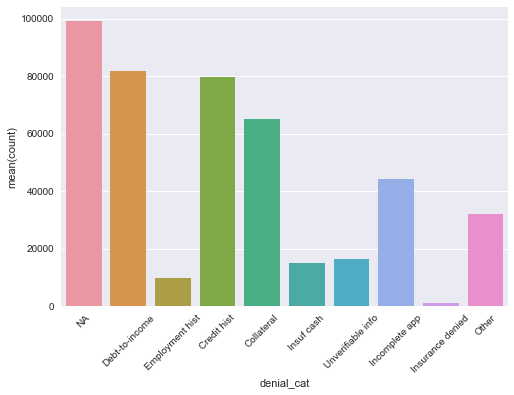

In [146]:
#print(hmda.loc[hmda['action_cat']=='reject',['denial1','denial_cat']])
hmda_view = hmda.groupby(['denial_cat','action_cat'])['loan_amount'].agg({'count':np.size}).reset_index()
hmda_view = hmda_view[hmda_view['action_cat']=='reject']
fig, ax = plt.subplots()
f1 = sns.barplot(x = 'denial_cat',y = 'count',data=hmda_view,ax=ax)
plt.setp(f1.get_xticklabels(), rotation=45)
plt.show()


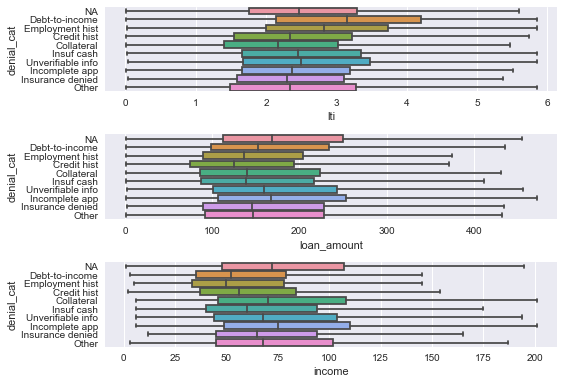

In [147]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
sns.boxplot(x="lti", y="denial_cat", data=hmda,showfliers = False,ax=ax1);

ax2 = fig.add_subplot(312)
sns.boxplot(x="loan_amount", y="denial_cat", data=hmda,showfliers = False,ax=ax2);

ax3 = fig.add_subplot(313)
sns.boxplot(x="income", y="denial_cat", data=hmda,showfliers = False,ax=ax3);

#ax4 = fig.add_subplot(414)
#sns.boxplot(x="tract2msa_income", y="denial_cat", data=hmda,showfliers = False,ax=ax4);

plt.tight_layout()
plt.show()


## Merge with Zillow to get mean house prices during 2013

I downloaded the Zillow house price index for Single Family Homes from this link:
http://www.zillow.com/research/data/

In [ ]:
zillow = pd.read_csv("County_Zhvi_SingleFamilyResidence.csv",index_col=False)
zillow = zillow[['StateCodeFIPS','MunicipalCodeFIPS','2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12']]
zillow.loc[:,'HPI'] = zillow.iloc[:,2:14].mean(numeric_only=True,axis=1) # Take the 2013 average house price index
zillow = zillow[['StateCodeFIPS','MunicipalCodeFIPS','HPI']]
zillow.columns = ['state','county','HPI']


In [ ]:

hmda.loc[hmda['county'].str.find('NA') >=0,'county'] = np.nan
hmda = hmda.loc[(pd.isnull(hmda['state']) == False) & (pd.isnull(hmda['county']) == False),:]
hmda.loc[:,'state'] = hmda.loc[:,'state'].astype(int)
hmda.loc[:,'county'] = hmda.loc[:,'county'].astype(int)

In [ ]:
hmda = hmda.merge(zillow,on=['state','county'],how='inner')

In [ ]:
hmda['ltv'] = (hmda['loan_amount']*1000)/hmda['HPI'] # Loan to value ratio
hmda['ltv'].describe()

In [ ]:
fig = plt.figure()
sns.boxplot(x="ltv", y="action_cat", data=hmda,showfliers = False)
plt.show()
